In [1]:
#pytorch related imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split,Dataset
import torchaudio
import torchaudio.transforms as T
import torch.optim as optim

c:\Users\iresh\anaconda3\envs\pyt-2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#other imports
import pandas as pd
import librosa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from datetime import datetime

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
dataSetPath = '../Datasets/Dataset1/Respiratory_Sound_Database/Respiratory_Sound_Database'


In [5]:
patient_data=pd.read_csv(dataSetPath+ "/patient_diagnosis.csv",names=['pid','disease'])
patient_data.head()



,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


c:\Users\iresh\anaconda3\envs\pyt-2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

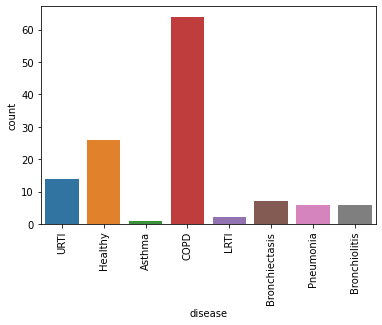

In [6]:
sns.countplot(patient_data.disease)
plt.xticks(rotation=90)

In [7]:
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = ["Asthma","COPD","Bronchiectasis","Pneumonia","URTI","Healthy","Bronchiolitis","LRTI"]
values = np.array(data)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[4])])

def EncodeOneHot(x):
    return onehot_encoder.transform([label_encoder.transform([x])])

def DecodeOneHot(lst =[]):
    return label_encoder.inverse_transform([argmax(lst)])

In [8]:
EncodeOneHot('Pneumonia')

array([[0., 0., 0., 0., 0., 0., 1., 0.]])

In [9]:
l = [0, 0, 1, 0, 0, 0, 0, 0]
DecodeOneHot(l)

array(['Bronchiolitis'], dtype='<U14')

In [10]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

# SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

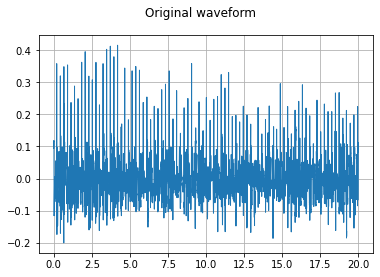

In [11]:
TEST_WAVEFORM, SAMPLE_RATE = torchaudio.load(dataSetPath + '/audio_and_txt_files/'+'101_1b1_Al_sc_Meditron.wav')
plot_waveform(TEST_WAVEFORM, SAMPLE_RATE, title="Original waveform")

In [12]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(TEST_WAVEFORM)
print (mfcc.shape)

c:\Users\iresh\anaconda3\envs\pyt-2\lib\site-packages\torchaudio\functional\functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


torch.Size([1, 256, 1723])


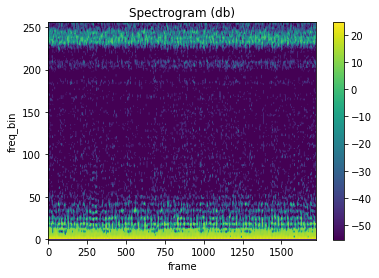

In [13]:
plot_spectrogram(mfcc[0])

In [14]:
def getLable (fileName):
    #this function returns the decease lable when file name was given as the argument
    pid = int(fileName.split('_')[0])             # get pid from file name
    labelPd = patient_data[patient_data['pid'] == pid]          # find correct row
    label = labelPd.iat[0,1]                                    # extract label
    encodedLabel = EncodeOneHot(label)                          #reencode to onehot
    return label

In [15]:

print (getLable('101_1b1_Al_sc_Meditron.wav'))





URTI


In [16]:

# # samples use to tune spectrogram parameters
# sample_cases_for_tuning = ['101_1b1_Al_sc_Meditron','102_1b1_Ar_sc_Meditron','103_2b2_Ar_mc_LittC2SE','107_2b3_Al_mc_AKGC417L','108_1b1_Al_sc_Meditron','111_1b2_Tc_sc_Meditron','122_2b1_Tc_mc_LittC2SE','216_1b1_Al_sc_Meditron']
# rows = 2
# cols = 4
# n = rows * cols
# j=0
# r=0
# c=0
# #fig, axes = plt.subplots()
# figure, axes = plt.subplots(rows, cols, figsize=(18, 12))
# for i in sample_cases_for_tuning:
#     j = j + 1
#     lable = getLable(i)
#     WAVEFORM, SAMPLE_RATE = torchaudio.load(dataSetPath + '/audio_and_txt_files/'+ i +'.wav')

#     waveform = WAVEFORM.numpy()
    
#     num_channels, num_frames = waveform.shape
#     time_axis = torch.arange(0, num_frames) / SAMPLE_RATE
#     print (str(lable) + " length : " + str(len(waveform[0])))

   
#     ax = axes[r][c]
#     r = j // cols
#     c = j % cols
    
#     ax.plot(time_axis, waveform[0], linewidth=1)
#     #axes.grid(True)
#     label = lable
#     ax.set_title(lable)
#     #figure.suptitle(lable)
# plt.show()



(256, 1723)
URTI length : 256
(256, 1723)
Healthy length : 256
(256, 1723)
Asthma length : 256
(256, 1723)
COPD length : 256
(256, 1723)
LRTI length : 256
(256, 1723)
Bronchiectasis length : 256
(256, 1723)
Pneumonia length : 256
(256, 1723)
Bronchiolitis length : 256


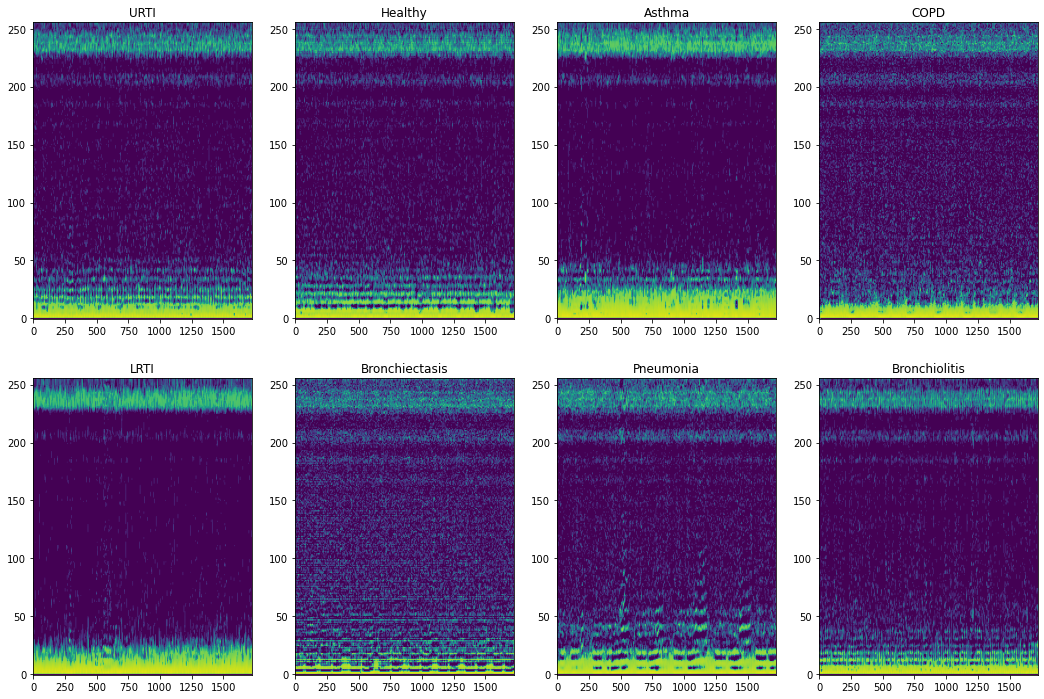

In [19]:
sample_cases_for_tuning = ['101_1b1_Al_sc_Meditron','102_1b1_Ar_sc_Meditron','103_2b2_Ar_mc_LittC2SE','107_2b3_Al_mc_AKGC417L','108_1b1_Al_sc_Meditron','111_1b2_Tc_sc_Meditron','122_2b1_Tc_mc_LittC2SE','216_1b1_Al_sc_Meditron']
rows = 2
cols = 4
n = rows * cols
j=0
r=0
c=0
#fig, axes = plt.subplots()
figure, axes = plt.subplots(rows, cols, figsize=(18, 12))
for i in sample_cases_for_tuning:
    j = j + 1
    lable = getLable(i)
    WAVEFORM, SAMPLE_RATE = torchaudio.load(dataSetPath + '/audio_and_txt_files/'+ i +'.wav')

    waveform = mfcc_transform(WAVEFORM).numpy()
    print (waveform[0].shape)
    num_channels, num_frames = waveform[0].shape
    time_axis = torch.arange(0, num_frames) / SAMPLE_RATE
    print (str(lable) + " length : " + str(len(waveform[0])))

   
    ax = axes[r][c]
    r = j // cols
    c = j % cols
    
    # ax.plot(time_axis, waveform[0], linewidth=1)
    ax.imshow(librosa.power_to_db(waveform[0]), origin="lower", aspect="auto")
    #axes.grid(True)
    label = lable
    ax.set_title(lable)
    #figure.suptitle(lable)

    # fig, axs = plt.subplots(1, 1)
    # axs.set_title(title or "Spectrogram (db)")
    # axs.set_ylabel(ylabel)
    # axs.set_xlabel("frame")
    # im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    # fig.colorbar(im, ax=axs)
    # plt.show(block=False)
plt.show()

In [ ]:
class LungSoundDataSet(Dataset):
    def __init__(self,patient_data_labels, file_list):
        self.patient_data_labels = patient_data_labels
        # self.data_file_list = file_list
        self.audioFiles =file_list
        # for file in os.listdir(data_file_path):
        #     if file.endswith('.wav'):
        #         self.audioFiles.append (file)

    def __getitem__(self, index):
        # get correct label
        pid = int(self.audioFiles[index].split('_')[0])             # get pid from file name
        labelPd = patient_data[patient_data['pid'] == pid]          # find correct row
        label = labelPd.iat[0,1]                                    # extract label
        encodedLabel = EncodeOneHot(label)

        path = dataSetPath + '/audio_and_txt_files/'+ self.audioFiles[index]
        sound,sample_rate  = torchaudio.load(path)
        soundData = torch.mean(sound, dim=0, keepdim=True)
        #load returns a tensor with the sound data and the sampling frequency 
        outSound = []
        # print(self.files[index])
        tempData = torch.zeros([800000])
       
        #to zero pad shorter sound files
        if (sound.numel() > 800000):
            tempData = torch.narrow(sound ,1 ,0,800000)
        if (sound.numel() < 800000):
            tempData[:sound.numel()] = sound
        
            
        sound = tempData
        # print (sound.numel())
        downSamSound = sound         #to be chaged

        #mel_specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(downSamSound)  # (channel, n_mels, time)
        mel_specgram = mfcc_transform(downSamSound)

        # mel_specgram_norm = (mel_specgram - mel_specgram.mean()) / mel_specgram.std()
        # mfcc = torchaudio.transforms.MFCC(sample_rate=sample_rate)(downSamSound)  # (channel, n_mfcc, time)
        
        # mfcc_norm = (mfcc - mfcc.mean()) / mfcc.std()
        # spectogram = torchaudio.transforms.Spectrogram(sample_rate=sample_rate)(soundData)
        # feature = torch.cat([mel_specgram, mfcc], axis=1)

        feature = mel_specgram
        # print(feature.shape)
        if (feature.shape != [1, 256, 1563]):
            # print(feature.shape)
            feature = feature.expand(1,256,1563)
            # print(feature.shape)
        x = feature[0].permute(1, 0)
       
        # print (encodedLabel)
        return feature[0].permute(1, 0),encodedLabel[0]

        # return mel_specgram,encodedLabel
        
    def __len__(self):
        return len(self.audioFiles)

In [ ]:
#generate array to store .wav file names
file_list = []
file_path = '../Datasets/Dataset1/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
for file in os.listdir(file_path):
    if file.endswith('.wav'):
        file_list.append (file)
lenDataSet = len(file_list)# Define relevant variables for the ML task
batch_size = 32
num_classes = 8
learning_rate = 0.001
num_epochs = 20
weight_decay = 0.0001

In [ ]:
train_set = LungSoundDataSet(patient_data,file_list[:int(lenDataSet * 0.6)])
test_set = LungSoundDataSet(patient_data,file_list[int(lenDataSet * 0.6):int(lenDataSet * 0.8)])
val_set = LungSoundDataSet(patient_data,file_list[int(lenDataSet * 0.8):])

print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))
print("Val set size: " + str(len(val_set)))

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}  # needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)


Train set size: 552
Test set size: 184
Val set size: 184


In [ ]:
# Creating a CNN class
class CNNAudio(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(CNNAudio, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(23607, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 8)
    
    # Progresses data across layers    
    def forward(self, x):

       
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
model = CNNAudio(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.005)  

total_step = len(train_loader)

In [ ]:
# model = AudioLSTM(n_feature=hyperparameters["in_feature"], out_feature=hyperparameters["out_feature"])
model.to(device)
print(model)

CNNAudio(
  (conv_layer1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=23607, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=8, bias=True)
)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss = []
def train(model, epoch):
    model.train()
    tr_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        model.zero_grad()
        output= model(data)
        loss = criterion(output, target)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))
        tr_loss.append(loss)
    train_loss.append(torch.mean(torch.FloatTensor(tr_loss)))

In [ ]:
def test(model, epoch):
    model.eval()
    correct = 0
    y_pred, y_target = [], []
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        print (output.shape)
        pred = torch.max(output, dim=1).indices
        print (pred)
        print(pred.shape)
        print (pred.eq(target))
        correct += pred.eq(target).cpu().sum().item()
        y_pred = y_pred + pred.tolist()
        y_target = y_target + target.tolist()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
clip = 5  # gradient clipping
n_epoch = 3
log_interval = 10
# transform = transform.to(device)
for epoch in range(1, n_epoch+1):
    # scheduler.step()
    train(model, epoch)
    test(model, epoch)

Train Epoch: 1 [0/552 (0%)]	Loss: 2.375271
Train Epoch: 1 [320/552 (59%)]	Loss: 3.235211
torch.Size([32, 8])
tensor([3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 1, 7, 3, 3, 3, 3, 3,
        3, 3, 7, 3, 3, 3, 7, 3], device='cuda:0')
torch.Size([32])


RuntimeError: The size of tensor a (32) must match the size of tensor b (8) at non-singleton dimension 1

In [ ]:
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        print(len(images))
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))